In [14]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
database_path = kagglehub.dataset_download('kaustubhdikshit/neu-surface-defect-database')

print('Data source import complete.')
print(f"Dataset downloaded to: {database_path}")


Using Colab cache for faster access to the 'neu-surface-defect-database' dataset.
Data source import complete.
Dataset downloaded to: /kaggle/input/neu-surface-defect-database


In [15]:

import numpy as np
from tensorflow.keras.utils import plot_model
import tensorflow.keras.backend as K
from PIL import Image
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow.keras import layers, models, optimizers
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, BatchNormalization, GlobalAveragePooling2D,
                                     AvgPool2D, multiply, Lambda, Dropout, Dense)
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau,LearningRateScheduler

In [16]:

train_dir = '/kaggle/input/neu-surface-defect-database/NEU-DET/train/images'
val_dir = '/kaggle/input/neu-surface-defect-database/NEU-DET/validation/images'

/tmp/ipython-input-1382232629.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts.keys()), y=list(counts.values()), palette='Set2')


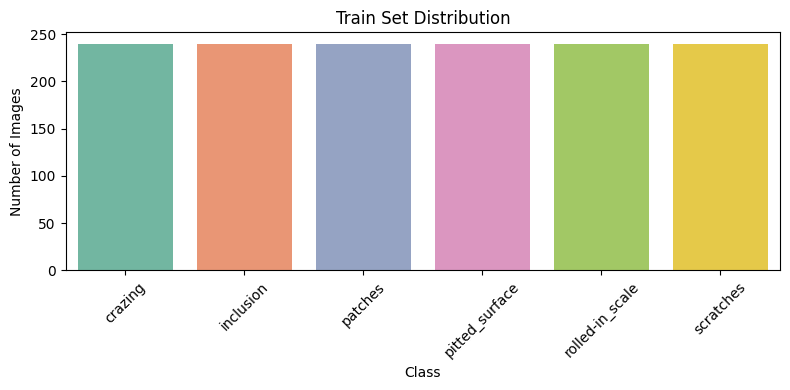

/tmp/ipython-input-1382232629.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts.keys()), y=list(counts.values()), palette='Set2')


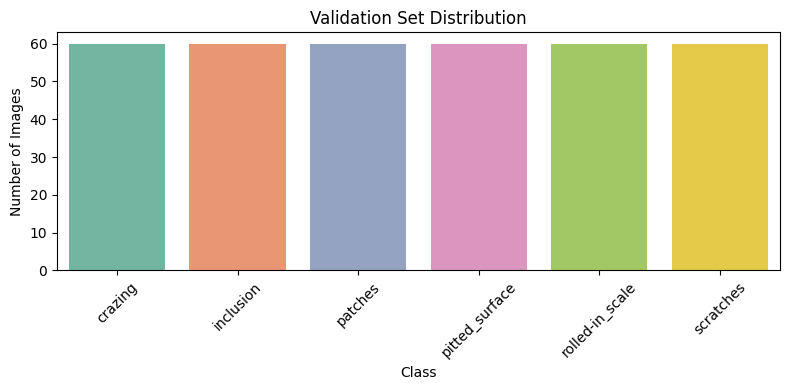

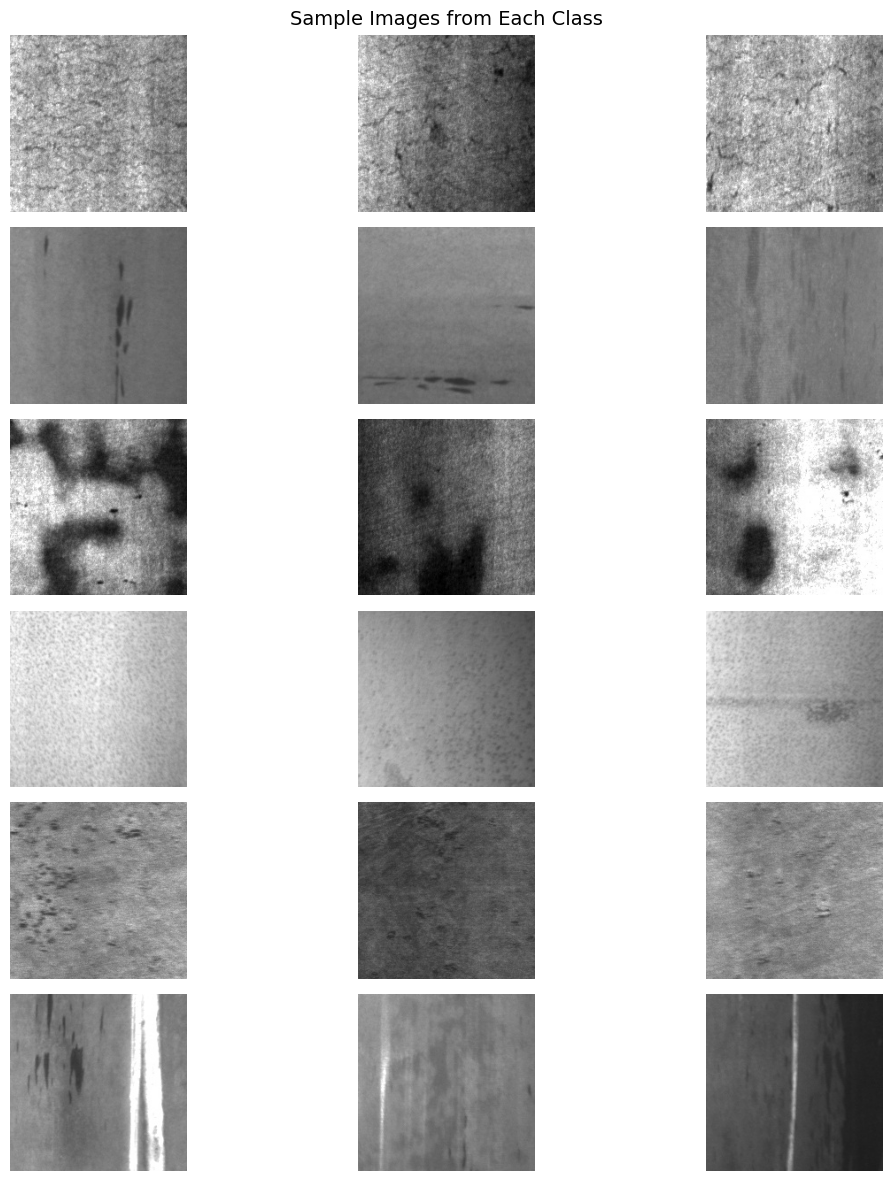

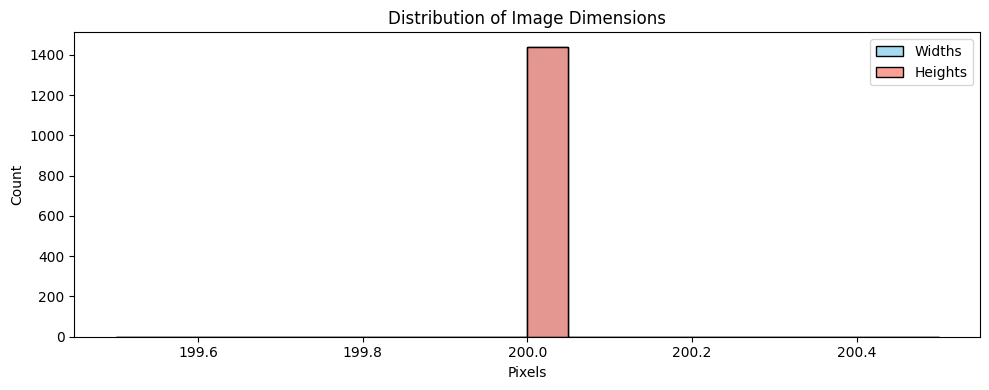

📏 تعداد کل تصاویر بررسی شده: 1440
میانگین اندازه عرض × ارتفاع: 200 × 200


In [17]:




train_classes = sorted(os.listdir(train_dir))
val_classes = sorted(os.listdir(val_dir))


def count_images_per_class(data_dir):
    class_counts = {}
    for class_name in sorted(os.listdir(data_dir)):
        class_path = os.path.join(data_dir, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len([
                f for f in os.listdir(class_path)
                if f.lower().endswith(('.png', '.jpg', '.jpeg'))
            ])
    return class_counts

train_counts = count_images_per_class(train_dir)
val_counts = count_images_per_class(val_dir)


def plot_class_distribution(counts, title):
    plt.figure(figsize=(8, 4))
    sns.barplot(x=list(counts.keys()), y=list(counts.values()), palette='Set2')
    plt.title(title)
    plt.ylabel("Number of Images")
    plt.xlabel("Class")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_class_distribution(train_counts, "Train Set Distribution")
plot_class_distribution(val_counts, "Validation Set Distribution")


def show_sample_images(data_dir, classes, num_samples=3):
    plt.figure(figsize=(12, len(classes)*2))
    for i, class_name in enumerate(classes):
        class_path = os.path.join(data_dir, class_name)
        image_files = [
            f for f in os.listdir(class_path)
            if f.lower().endswith(('.png', '.jpg', '.jpeg'))
        ][:num_samples]
        for j, img_name in enumerate(image_files):
            img_path = os.path.join(class_path, img_name)
            img = Image.open(img_path)
            plt.subplot(len(classes), num_samples, i * num_samples + j + 1)
            plt.imshow(img, cmap='gray')
            plt.axis('off')
            if j == 0:
                plt.ylabel(class_name, fontsize=12)
    plt.suptitle("Sample Images from Each Class", fontsize=14)
    plt.tight_layout()
    plt.show()

show_sample_images(train_dir, train_classes, num_samples=3)


def analyze_image_sizes(data_dir):
    image_shapes = []
    for class_name in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_name)
        for img_file in os.listdir(class_path):
            if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(class_path, img_file)
                try:
                    img = Image.open(img_path)
                    image_shapes.append(img.size)  # (width, height)
                except:
                    continue
    return image_shapes

shapes = analyze_image_sizes(train_dir)
widths, heights = zip(*shapes)

# 📐 نمودار ابعاد
plt.figure(figsize=(10, 4))
sns.histplot(widths, bins=20, color='skyblue', label='Widths')
sns.histplot(heights, bins=20, color='salmon', label='Heights')
plt.title("Distribution of Image Dimensions")
plt.xlabel("Pixels")
plt.legend()
plt.tight_layout()
plt.show()

print(f"📏 تعداد کل تصاویر بررسی شده: {len(shapes)}")
print(f"میانگین اندازه عرض × ارتفاع: {int(np.mean(widths))} × {int(np.mean(heights))}")

In [18]:

data_gen = ImageDataGenerator(rescale=1/255.0)

train_data = data_gen.flow_from_directory(
    train_dir, target_size=(200, 200), batch_size=16,
    class_mode='categorical', shuffle=True
)

val_data = data_gen.flow_from_directory(
    val_dir, target_size=(200, 200), batch_size=16,
    class_mode='categorical', shuffle=False
)


def extract_all_data(generator):
    x, y = [], []
    for _ in range(len(generator)):
        images, labels = next(generator)
        x.append(images)
        y.append(labels)
    return np.concatenate(x), np.concatenate(y)

x_train, y_train = extract_all_data(train_data)
x_val, y_val = extract_all_data(val_data)
class_labels = list(train_data.class_indices.keys())


Found 1440 images belonging to 6 classes.
Found 360 images belonging to 6 classes.


Found 1440 images belonging to 6 classes.
Found 360 images belonging to 6 classes.
(200, 200, 3)


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 200, 200,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 200, 200,  │      1,792 │ input_layer_2[0]… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 200, 200,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 100, 100,  │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 100, 100,  │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 100, 100,  │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 50, 50,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 50, 50,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 50, 50,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 50, 50,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 25, 25,    │          0 │ block3_conv3[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 25, 25,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 25, 25,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 25, 25,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 12, 12,    │          0 │ block4_conv3[0][… │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv1        │ (None, 12, 12,    │  2,359,808 │ block4_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv2        │ (None, 12, 12,    │  2,359,808 │ block5_conv1[0][

 Total params: 14,854,023 (56.66 MB)

 Trainable params: 137,799 (538.28 KB)

 Non-trainable params: 14,716,224 (56.14 MB)

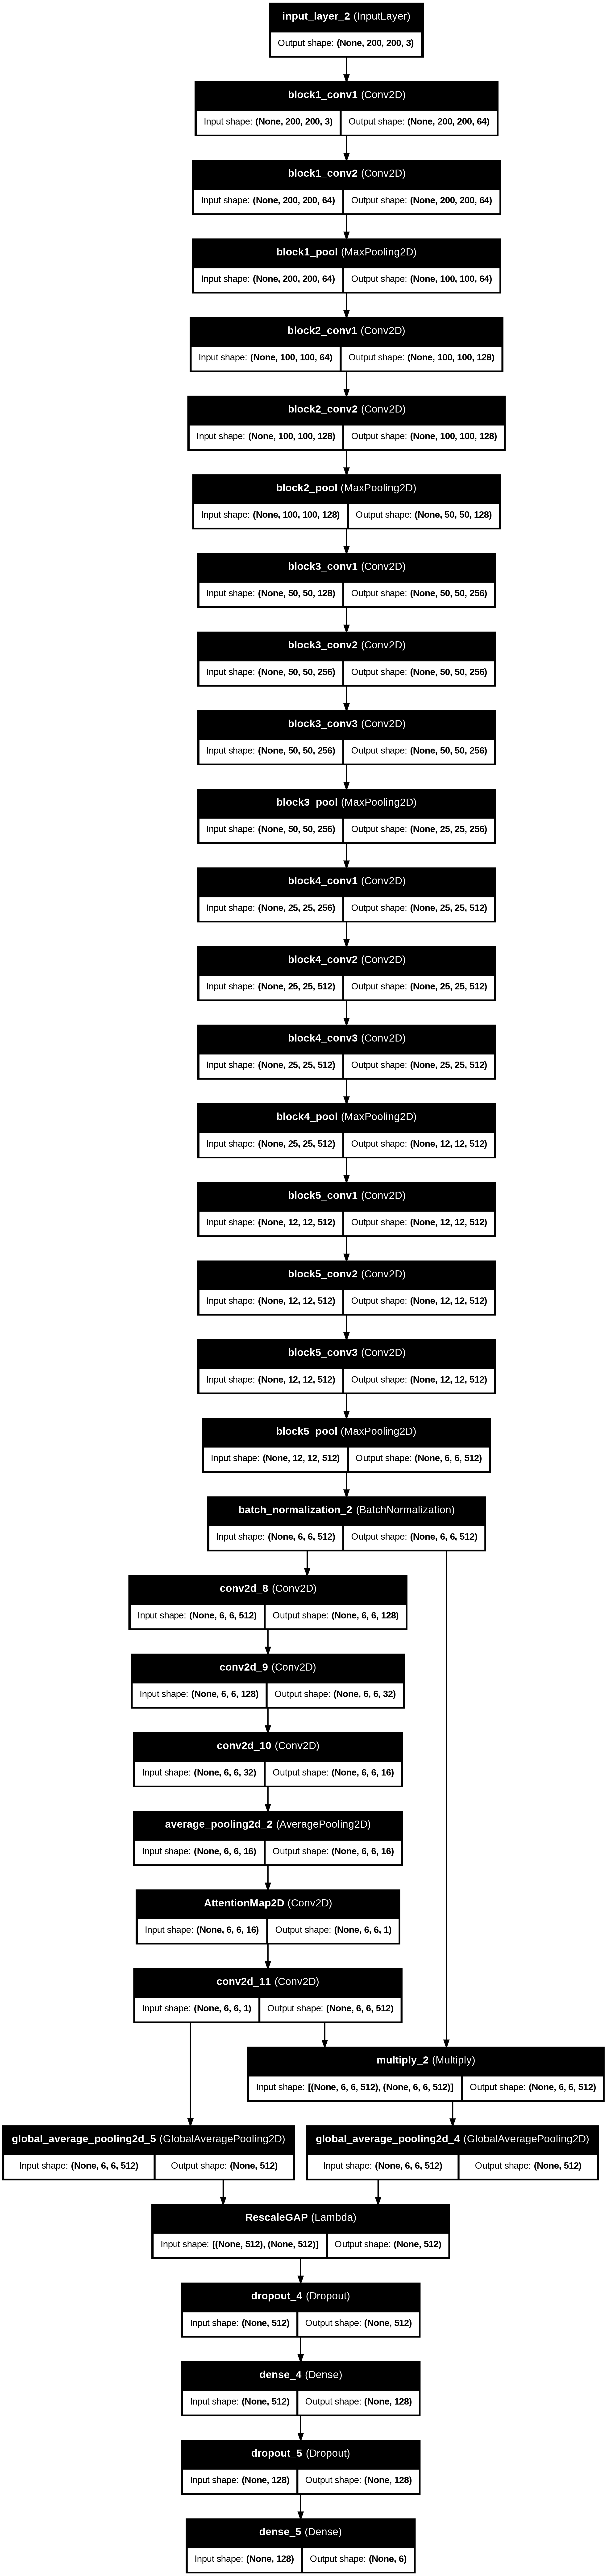

In [19]:

data_gen = ImageDataGenerator(rescale=1/255.0)

train_data = data_gen.flow_from_directory(
    train_dir, target_size=(200, 200), batch_size=16,
    class_mode='categorical', shuffle=True
)

val_data = data_gen.flow_from_directory(
    val_dir, target_size=(200, 200), batch_size=16,
    class_mode='categorical', shuffle=False
)


def extract_all_data(generator):
    x, y = [], []
    for _ in range(len(generator)):
        images, labels = next(generator)
        x.append(images)
        y.append(labels)
    return np.concatenate(x), np.concatenate(y)

x_train, y_train = extract_all_data(train_data)
x_val, y_val = extract_all_data(val_data)
class_labels = list(train_data.class_indices.keys())
print(x_train.shape[1:])

input_layer = Input(shape=x_train.shape[1:])
base_model = VGG16(include_top=False, input_tensor=input_layer, weights='imagenet')
base_model.trainable = False

pt_features = base_model.output
pt_depth = base_model.output_shape[-1]
bn_features = BatchNormalization()(pt_features)

attn = Conv2D(128, (1, 1), activation='elu', padding='same')(bn_features)
attn = Conv2D(32, (1, 1), activation='elu', padding='same')(attn)
attn = Conv2D(16, (1, 1), activation='elu', padding='same')(attn)
attn = AvgPool2D(pool_size=(2, 2), strides=(1, 1), padding='same')(attn)
attn = Conv2D(1, (1, 1), activation='sigmoid', name='AttentionMap2D')(attn)

up_c2 = Conv2D(pt_depth, (1, 1), padding='same', activation='linear', use_bias=False, trainable=False)
attn = up_c2(attn)
up_c2.set_weights([np.ones((1, 1, 1, pt_depth))])

masked_features = multiply([attn, bn_features])
gap_feat = GlobalAveragePooling2D()(masked_features)
gap_attn = GlobalAveragePooling2D()(attn)
rescaled_gap = Lambda(lambda x: x[0] / (x[1] + 1e-7), name='RescaleGAP')([gap_feat, gap_attn])

gap_dropout = Dropout(0.5)(rescaled_gap)
dense = Dense(128, activation='elu')(gap_dropout)
dense_dropout = Dropout(0.25)(dense)
output = Dense(len(class_labels), activation='softmax')(dense_dropout)

model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()
plot_model(model, to_file='model_attention_vgg16.png', show_shapes=True, show_layer_names=True)

In [20]:
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, Callback # Callback را اضافه کنید

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=1)
]
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0,
    patience=0,
    verbose=1,
    mode='max',

)

history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),

    epochs=50,
    batch_size=64,
    callbacks=[early_stopping]


)

Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 18s 557ms/step - accuracy: 0.6377 - loss: 0.9924 - val_accuracy: 0.5972 - val_loss: 1.2919
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 344ms/step - accuracy: 0.9443 - loss: 0.2030 - val_accuracy: 0.7722 - val_loss: 0.9948
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 397ms/step - accuracy: 0.9589 - loss: 0.1359 - val_accuracy: 0.8222 - val_loss: 0.8281
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 357ms/step - accuracy: 0.9723 - loss: 0.0866 - val_accuracy: 0.8861 - val_loss: 0.6808
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 356ms/step - accuracy: 0.9825 - loss: 0.0639 - val_accuracy: 0.9139 - val_loss: 0.5652
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 390ms/step - accuracy: 0.9858 - loss: 0.0493 - val_accuracy: 0.9472 - val_loss: 0.4330
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 386ms/step - accuracy: 0.9819 - loss: 0.0588 - val_accuracy: 0.9750 - val_loss: 0.3326
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 340ms/step - accuracy: 0.9874 - loss: 0.0551 - val_accuracy

12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 526ms/step

Classification Report:

                 precision    recall  f1-score   support

        crazing       1.00      1.00      1.00        60
      inclusion       0.94      1.00      0.97        60
        patches       1.00      1.00      1.00        60
 pitted_surface       0.98      0.95      0.97        60
rolled-in_scale       1.00      0.98      0.99        60
      scratches       1.00      0.98      0.99        60

       accuracy                           0.99       360
      macro avg       0.99      0.99      0.99       360
   weighted avg       0.99      0.99      0.99       360



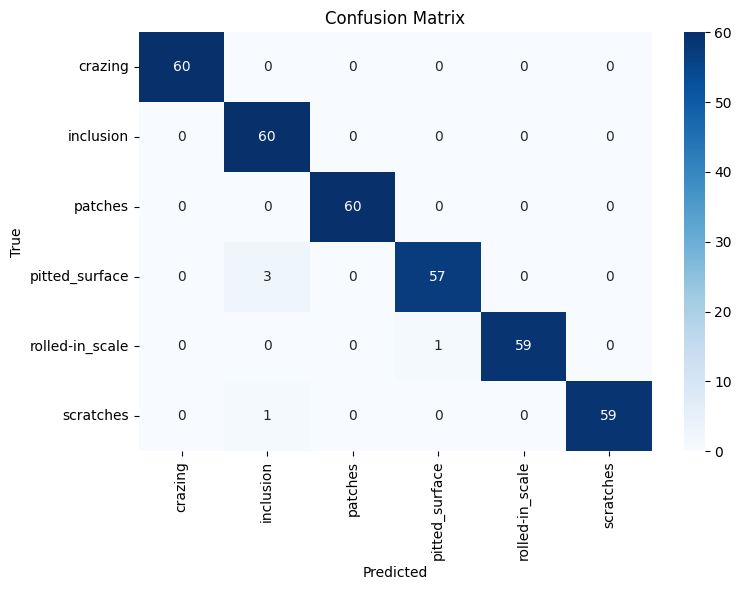

In [21]:

y_pred = model.predict(x_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val, axis=1)

print("\nClassification Report:\n")
print(classification_report(y_true_classes, y_pred_classes, target_names=class_labels))

# confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300)
plt.show()

In [22]:
model.save('/foulad_model.h5')

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step
Accuracy : 0.9997592592592591
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       0.94      1.00      0.97        60
           2       1.00      1.00      1.00        60
           3       0.98      0.95      0.97        60
           4       1.00      0.98      0.99        60
           5       1.00      0.98      0.99        60

    accuracy                           0.99       360
   macro avg       0.99      0.99      0.99       360
weighted avg       0.99      0.99      0.99       360

[[60  0  0  0  0  0]
 [ 0 60  0  0  0  0]
 [ 0  0 60  0  0  0]
 [ 0  3  0 57  0  0]
 [ 0  0  0  1 59  0]
 [ 0  1  0  0  0 59]]
The sensitivity score achieved using random forest is: 1.0 %
The specificity score achieved using random forest is: 1.0 %


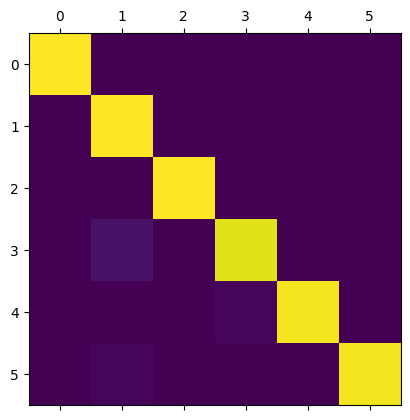

In [23]:
pred_Y = model.predict(x_val, batch_size = 32, verbose = True)
pred_Y_cat = np.argmax(pred_Y,-1)
test_Y_cat = np.argmax(y_val, -1)

from sklearn.metrics import classification_report, accuracy_score,roc_auc_score, confusion_matrix
plt.matshow(confusion_matrix(test_Y_cat, pred_Y_cat))
#print('Accuracy %2.2f%%' % (100*accuracy_score(test_Y, pred_Y)))
accuracy_score=roc_auc_score(y_val, pred_Y)
#ac=ac+0.20
print ("Accuracy :",accuracy_score)

print(classification_report(test_Y_cat, pred_Y_cat))
confusion = confusion_matrix(test_Y_cat, pred_Y_cat)
print(confusion)
#[row, column]
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

sensitivity = TP / float(FN + TP)

print("The sensitivity score achieved using random forest is: "+str(sensitivity)+" %")
specificity = TN / (TN + FP)
print("The specificity score achieved using random forest is: "+str(specificity)+" %")

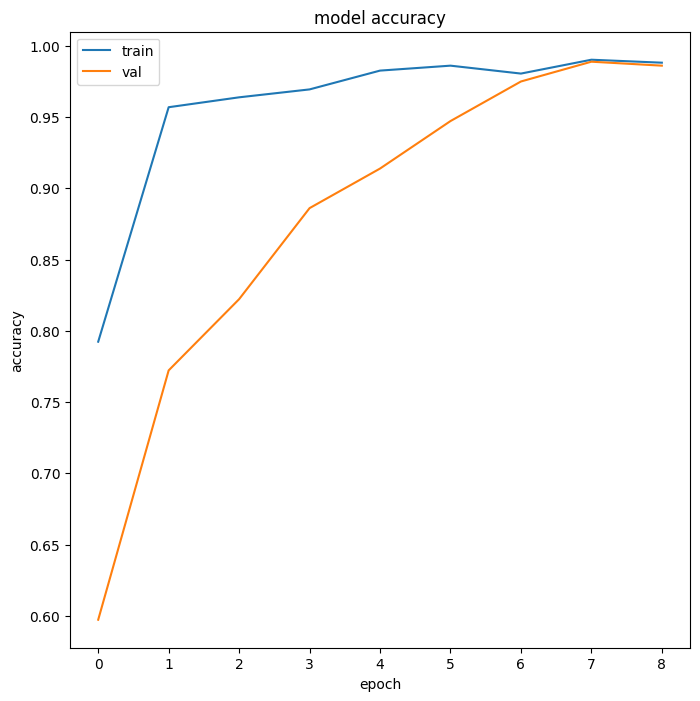

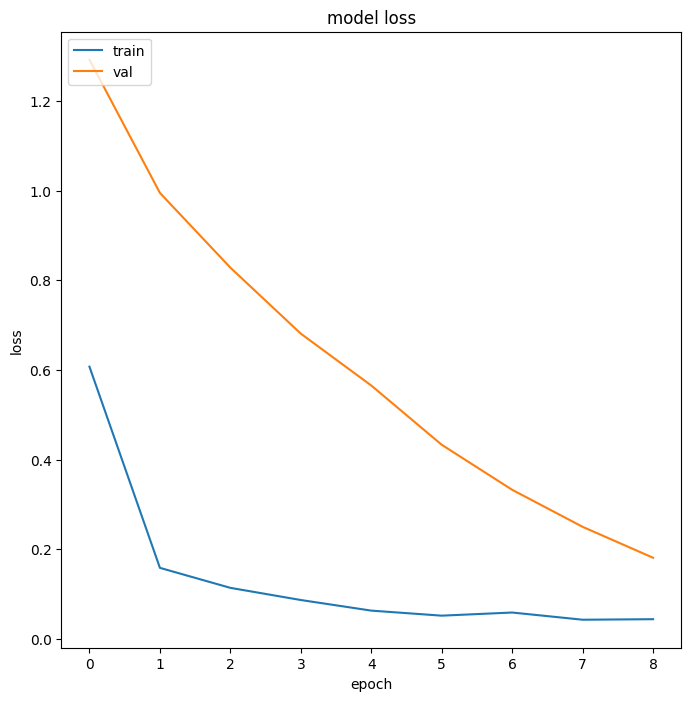


📌 Precision (macro avg): 0.9867
📌 Recall (macro avg): 0.9861
📌 mAP (macro average precision): 0.9989


In [25]:
from tensorflow.keras.models import load_model
#model = load_model('foulad_attention_model_final.h5')
import os
import cv2
import random
import matplotlib.pyplot as plt
from PIL import Image


plt.rcParams["figure.figsize"] = (8,8)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# نمایش هستوگرام خطای مذل
plt.rcParams["figure.figsize"] = (8,8)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
from sklearn.metrics import precision_score, recall_score, average_precision_score


y_true_classes = np.argmax(y_val, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)

precision = precision_score(y_true_classes, y_pred_classes, average='macro')
print(f"\n📌 Precision (macro avg): {precision:.4f}")


recall = recall_score(y_true_classes, y_pred_classes, average='macro')
print(f"📌 Recall (macro avg): {recall:.4f}")


try:
    map_score = average_precision_score(y_val, y_pred, average='macro')
    print(f"📌 mAP (macro average precision): {map_score:.4f}")
except:
    print("⚠️ Cannot compute mAP: Make sure y_val and y_pred are properly shaped.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


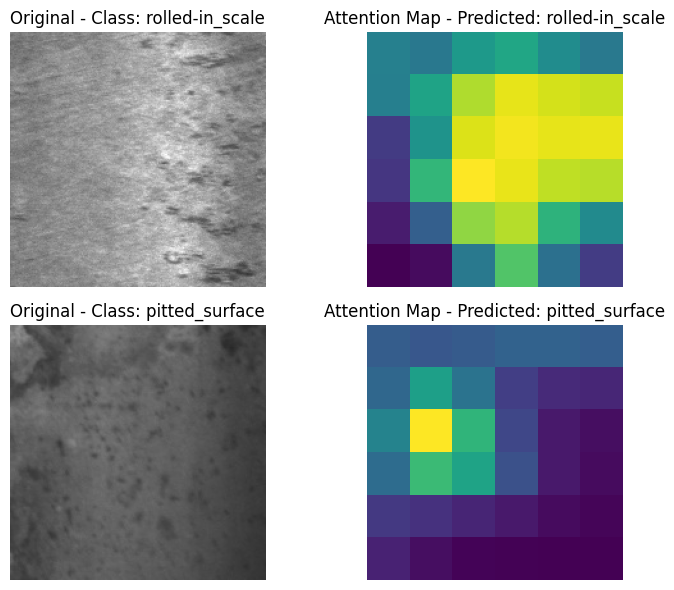

In [26]:


attn_layer = model.get_layer('AttentionMap2D')


attn_model = Model(inputs=model.input, outputs=attn_layer.output)


rand_idx = np.random.choice(range(len(x_val)), size=2, replace=False)
fig, axs = plt.subplots(2, 2, figsize=(8, 6))

# رسم تصاویر اصلی و Attention Map
for i, idx in enumerate(rand_idx):
    image = x_train[idx:idx+1]
    attn_map = attn_model.predict(image)

    # تصویر اصلی
    axs[i, 0].imshow(image[0])
    axs[i, 0].set_title(f'Original - Class: {class_labels[np.argmax(y_train[idx])]}')
    axs[i, 0].axis('off')

    # نقشه توجه
    axs[i, 1].imshow(attn_map[0, :, :, 0], cmap='viridis')
    pred_class = class_labels[np.argmax(model.predict(image, verbose=0))]
    axs[i, 1].set_title(f'Attention Map - Predicted: {pred_class}')
    axs[i, 1].axis('off')

plt.tight_layout()
plt.savefig('attention_maps.png', dpi=300)
plt.show()


# ذخیره مدل نهایی

[INFO] Making new prediction...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


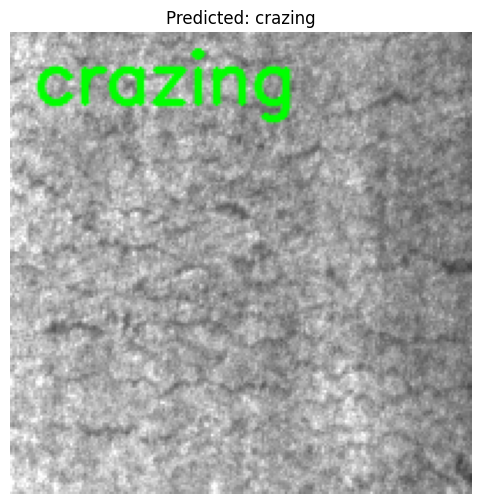

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 732ms/step


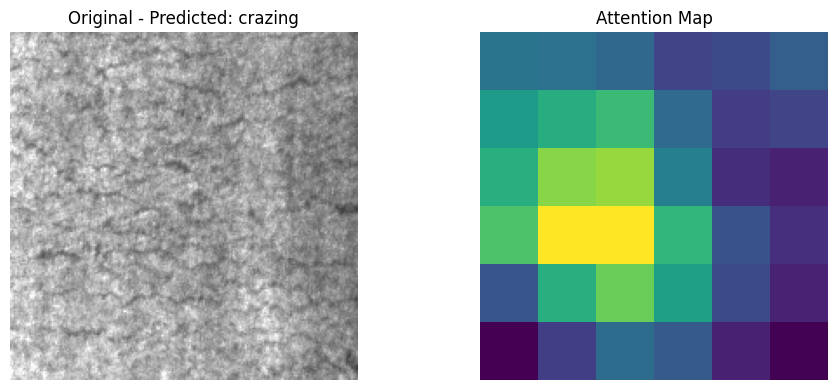

In [27]:

# تست روی یک تصویر جدید
print("[INFO] Making new prediction...")
new_image_path = '/kaggle/input/neu-surface-defect-database/NEU-DET/train/images/crazing/crazing_1.jpg'
new_image = cv2.imread(new_image_path)
new_image = cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB)
new_image = cv2.resize(new_image, (200, 200))
input_image = new_image.astype(np.float32) / 255.0
input_image = np.expand_dims(input_image, axis=0)

prediction = model.predict(input_image)
pred_index = np.argmax(prediction, axis=1)[0]
pred_label = class_labels[pred_index]

# نمایش تصویر با برچسب پیش‌بینی شده
font = cv2.FONT_HERSHEY_SIMPLEX
cv2.putText(new_image, pred_label, (10, 30), font, 1, (0, 255, 0), 2, cv2.LINE_AA)

plt.figure(figsize=(6,6))
plt.imshow(new_image)
plt.title(f"Predicted: {pred_label}")
plt.axis('off')
plt.show()

# بارگذاری تصویر ورودی فرضی
new_image_path = '/kaggle/input/neu-surface-defect-database/NEU-DET/train/images/crazing/crazing_1.jpg'
new_image = cv2.imread(new_image_path)
new_image = cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB)
new_image = cv2.resize(new_image, (200, 200))
input_image = new_image.astype(np.float32) / 255.0
input_image = np.expand_dims(input_image, axis=0)

# پیش‌بینی برای نمایش عنوان
prediction = model.predict(input_image)
pred_index = np.argmax(prediction, axis=1)[0]
pred_label = class_labels[pred_index]

attn_layer = model.get_layer('AttentionMap2D')
attn_model = Model(inputs=model.input, outputs=attn_layer.output)

attn_map_input = attn_model.predict(input_image)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(new_image)
plt.title(f'Original - Predicted: {pred_label}')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(attn_map_input[0, :, :, 0], cmap='viridis')
plt.title('Attention Map')
plt.axis('off')

plt.tight_layout()
plt.savefig('attention_map_input_image.png', dpi=300)
plt.show()